In [2]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt


from PIL import Image
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (22, 5)
plt.rcParams['figure.dpi'] = 100

In [3]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

In [4]:
df = pd.read_csv('../working/video_comments_fake_video_28102023.csv')
df_wcom = pd.read_csv('../working/video_without_comments_fake_video_28102023.csv')

In [5]:
df.shape, df_wcom.shape

((85228, 31), (87, 24))

In [10]:
df_wcom.head()

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,video_length,video_channel_id,video_channel_url,video_description,video_publish_date,video_rating,video_thumbnail_url,video_views,video_age_restricted,target_label
0,gfc_9,2023-10-27 00:00:00+00:00,https://factly.in/old-unrelated-are-being-shar...,FACTLY,old & unrelated are being shared as us militar...,a social media post featuring a video displayi...,https://www.youtube.com/watch?v=JDpawoSVi-M,en,MISLEADING,NaN,...,600.00,UCfMBT2axMq0jhZI5OA6paVg,https://www.youtube.com/channel/UCfMBT2axMq0jh...,NaN,2023-10-21 00:00:00,NaN,https://i.ytimg.com/vi/JDpawoSVi-M/hqdefault.j...,6.00,False,fake
1,gfc_9,2023-10-27 00:00:00+00:00,https://factly.in/old-unrelated-are-being-shar...,FACTLY,old & unrelated are being shared as us militar...,a social media post featuring a video displayi...,https://www.youtube.com/watch?v=l7hhZjq_J60,en,MISLEADING,NaN,...,NaN,NaN,https://www.youtube.com/channel/None,NaN,NaN,NaN,https://img.youtube.com/vi/l7hhZjq_J60/maxresd...,NaN,NaN,fake
2,gfc_20,2023-10-27 00:00:00+00:00,https://dpa-factchecking.com/belgium/231026-99...,dpa,recycled footage from a drone on an aircraft c...,since the attack by the islamist movement hama...,https://www.youtube.com/watch?v=B6bDVhRNw00,fr,La vidéo en question compile des images montra...,NaN,...,30.00,UCKuSaHewQKWjR2wFuqfkMEA,https://www.youtube.com/channel/UCKuSaHewQKWjR...,NaN,2011-02-07 00:00:00,NaN,https://i.ytimg.com/vi/B6bDVhRNw00/hqdefault.j...,817.00,False,fake
3,gfc_22,2023-10-27 00:00:00+00:00,https://dpa-factchecking.com/netherlands/23102...,dpa,brandstichting at the politiebureau in bahrain...,volgens reports on telegram and facebook from ...,https://www.youtube.com/watch?v=YHENeJB5QsA,de,De bewering is fout. In de video wordt een pol...,NaN,...,NaN,NaN,https://www.youtube.com/channel/None,NaN,NaN,NaN,https://img.youtube.com/vi/YHENeJB5QsA/maxresd...,NaN,NaN,fake
4,gfc_23,2023-10-27 00:00:00+00:00,https://verafiles.org/articles/vera-files-fact...,Vera Files,vera files fact check: ‘bato’ dela rosa contra...,in a phone interview with senate reporters on ...,https://www.youtube.com/watch?v=qtkKg_TjqZk,en,False,NaN,...,1888.00,UC46YJ9p0d6MSUXRZFRZrwGQ,https://www.youtube.com/channel/UC46YJ9p0d6MSU...,NaN,2017-11-29 00:00:00,NaN,https://i.ytimg.com/vi/qtkKg_TjqZk/hq720.jpg,4322.00,False,fake


In [11]:
df.head()

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,video_views,video_age_restricted,CommentsData,commentText,replycount,publishedAt,likeCount,authorDisplayName,commentText_processed,comment_language
0,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,302463.00,False,Every single word she said was wisely thought ...,Every single word she said was wisely thought ...,2.00,2023-05-20T23:58:29Z,107.00,Sebastian Peretz,NaN,NaN
1,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,302463.00,False,Spoke three languages fluently with no detecta...,Spoke three languages fluently with no detecta...,31.00,2023-01-10T22:27:12Z,157.00,sure why not,NaN,NaN
2,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,302463.00,False,"We need more leaders like her, women or men. S...","We need more leaders like her, women or men. S...",10.00,2018-09-16T16:24:02Z,148.00,elgrigorio1,NaN,NaN
3,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,302463.00,False,What a masterful interview by the Prime Minist...,What a masterful interview by the Prime Minister.,1.00,2023-10-21T20:05:04Z,12.00,Wasim Raja,NaN,NaN
4,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,302463.00,False,What an interview!!! She was very wise in he...,What an interview!!! She was very wise in he...,0.00,2023-10-13T19:47:49Z,15.00,Kelvin Quesenberry,NaN,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85228 entries, 0 to 85227
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   News_ID                85228 non-null  object 
 1   publish_date           85228 non-null  object 
 2   Link                   85228 non-null  object 
 3   source_name            85228 non-null  object 
 4   title                  85228 non-null  object 
 5   text                   85228 non-null  object 
 6   youtube_link           85228 non-null  object 
 7   news_language          85228 non-null  object 
 8   label                  43995 non-null  object 
 9   all_link               4639 non-null   object 
 10  videoId                84983 non-null  object 
 11  video_url              85228 non-null  object 
 12  video_title            84983 non-null  object 
 13  video_author           84983 non-null  object 
 14  video_length           84983 non-null  float64
 15  vi

In [15]:
df['videoId'].nunique()

301

In [16]:
## Number of caggregateomments/news language
#df['comment_language'].nunique(), df['news_language'].nunique()

In [17]:
#df['comment_language'].value_counts('')

In [18]:
df.columns

Index(['News_ID', 'publish_date', 'Link', 'source_name', 'title', 'text',
       'youtube_link', 'news_language', 'label', 'all_link', 'videoId',
       'video_url', 'video_title', 'video_author', 'video_length',
       'video_channel_id', 'video_channel_url', 'video_description',
       'video_publish_date', 'video_rating', 'video_thumbnail_url',
       'video_views', 'video_age_restricted', 'CommentsData', 'commentText',
       'replycount', 'publishedAt', 'likeCount', 'authorDisplayName',
       'commentText_processed', 'comment_language'],
      dtype='object')

In [19]:
df['publish_date'].min(), df['publish_date'].max()

('2023-10-07', '2023-10-30 00:00:00+00:00')

In [9]:
#df['video_publish_date'].min(), df['video_publish_date'].max()

In [21]:
df['video_length'].min(), df['video_length'].max()

(4.0, 30128.0)

In [22]:
# number of unique users
df['authorDisplayName'].nunique(), df['video_author'].nunique()

(64245, 222)

In [16]:
df.isnull().sum()

News_ID                      0
publish_date                 0
Link                         0
source_name                  0
title                        0
text                         0
youtube_link                 0
news_language                0
label                    41233
all_link                 80589
videoId                    245
video_url                    0
video_title                245
video_author               245
video_length               245
video_channel_id           245
video_channel_url          245
video_description        85228
video_publish_date         245
video_rating             85228
video_thumbnail_url        245
video_views                245
video_age_restricted       245
CommentsData                 0
commentText              13643
replycount               13688
publishedAt              13688
likeCount                13688
authorDisplayName        13699
commentText_processed    85228
comment_language         85228
dtype: int64

In [13]:
# identify all categorical variables
cat_columns = df.select_dtypes(['object']).columns

In [14]:
len(cat_columns)

# convert all categorical variables to numeric
#df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x))

24

In [26]:
#df.info()

## Polarity - Sentiment Analysis

In [18]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  l


Packages:
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] bcp47............... BCP-47 Language Tags
  [ ] comparative_sentences Comparative Sentence Dataset
  [ ] dolch............... Dolch Word List
  [ ] extended_omw........ Extended Open Multilingual WordNet
  [ ] framenet_v15........ FrameNet 1.5
  [ ] framenet_v17........ FrameNet 1.7
  [ ] mwa_ppdb............ The monolingual word aligner (Sultan et al.
                           2015) subset of the Paraphrase Database.
  [ ] nombank.1.0......... NomBank Corpus 1.0
  [ ] nonbreaking_prefixes Non-Breaking Prefixes (Moses Decoder)
  [ ] omw-1.4............. Open Multilingual Wordnet
  [ ] panlex_swadesh...... PanLex Swadesh Corpora
  [ ] pe08................ Cross-Framework and Cross-Domain Parser
                           Evaluation Shared Task
  [ ] perluniprops........ perluniprops: Index of Unicode Version 7.0.0
                           character properties in Perl
  [ ] verbnet3............ Ve

Hit Enter to continue:  


  [ ] wordnet2022......... Open English Wordnet 2022
  [ ] wordnet31........... Wordnet 3.1

Collections:
  [P] all-corpora......... All the corpora
  [P] all-nltk............ All packages available on nltk_data gh-pages
                           branch
  [P] all................. All packages
  [P] book................ Everything used in the NLTK Book
  [P] popular............. Popular packages
  [P] tests............... Packages for running tests
  [ ] third-party......... Third-party data packages

([*] marks installed packages; [P] marks partially installed collections)

Download which package (l=list; x=cancel)?


  Identifier>  



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  all-corpora


       | 
       | Downloading package abc to /usr/share/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /usr/share/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package bcp47 to /usr/share/nltk_data...
       | Downloading package biocreative_ppi to
       |     /usr/share/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package brown to /usr/share/nltk_data...
       |   Package brown is already up-to-date!
       | Downloading package brown_tei to /usr/share/nltk_data...
       |   Package brown_tei is already up-to-date!
       | Downloading package cess_cat to /usr/share/nltk_data...
       |   Package cess_cat is already up-to-date!
       | Downloading package cess_esp to /usr/share/nltk_data...
       |   Package cess_esp is already up-to-date!
       | Downloading package chat80 to /usr/share/nltk_data...
       |   Package chat80 is already up-to-d

Downloader>  all-nltk


Command 'all-nltk' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  all-nltk


       | 
       | Downloading package abc to /usr/share/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /usr/share/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /usr/share/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /usr/share/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to
       |     /usr/share/nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package bcp47 to /usr/share/nltk_data...
       |   Package bcp47 is already up-to-date!
       | Downloading package biocreative_ppi to
       |     /usr/share/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package bllip_wsj_no_aux to

Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  all


       | 
       | Downloading package abc to /usr/share/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /usr/share/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /usr/share/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /usr/share/nltk_data...
       |   Package averaged_perceptron_tagger_ru is already up-to-
       |       date!
       | Downloading package basque_grammars to
       |     /usr/share/nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package bcp47 to /usr/share/nltk_data...
       |   Package bcp47 is already up-to-date!
       | Downloading package biocreative_ppi to
       |     /usr/share/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading pac

Downloader>  u



Nothing to update.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

In [20]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [6]:
print('Comments on videos - ', format(len(df['CommentsData'])))
print('Unique Videos - ', format(df['videoId'].nunique()))
print('Comments per Video -', format(int(len(df['CommentsData'])/df['videoId'].nunique())))

Comments on videos -  85228
Unique Videos -  301
Comments per Video - 283


In [8]:
# text analysis, first normalize case
#df['CommentsData'] = df['CommentsData'].str.lower()
# punctuations
df['CommentsData'] = df['CommentsData'].str.replace('[^\w\s]', '')
df['CommentsData'] = df['CommentsData'].str.replace('\d', '')
# stopwords
sw = stopwords.words('english')
df['CommentsData'] = df['CommentsData'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
# lemmatization/stemming
#df['CommentsData'] = df['CommentsData'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [7]:
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"([-?.!,/\"])", '', text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", "", text)
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub('\n\n','', text)
    text = text.rstrip().strip()
    return text

In [9]:
clean_comments = []
for i in range(len(df['CommentsData'])):
    try:
        clean_comments.append(clean_text(df['CommentsData'][i]))
    except:
        clean_comments.append('None')
    if i % 1000==0:
        print(f'{i} iteration(s) completed')
df['Clean_Comments'] = clean_comments

0 iteration(s) completed
1000 iteration(s) completed
2000 iteration(s) completed
3000 iteration(s) completed
4000 iteration(s) completed
5000 iteration(s) completed
6000 iteration(s) completed
7000 iteration(s) completed
8000 iteration(s) completed
9000 iteration(s) completed
10000 iteration(s) completed
11000 iteration(s) completed
12000 iteration(s) completed
13000 iteration(s) completed
14000 iteration(s) completed
15000 iteration(s) completed
16000 iteration(s) completed
17000 iteration(s) completed
18000 iteration(s) completed
19000 iteration(s) completed
20000 iteration(s) completed
21000 iteration(s) completed
22000 iteration(s) completed
23000 iteration(s) completed
24000 iteration(s) completed
25000 iteration(s) completed
26000 iteration(s) completed
27000 iteration(s) completed
28000 iteration(s) completed
29000 iteration(s) completed
30000 iteration(s) completed
31000 iteration(s) completed
32000 iteration(s) completed
33000 iteration(s) completed
34000 iteration(s) complete

In [10]:
#df["CommentsData"].apply(lambda x: TextBlob(x).words).head()

- Polarity is a float value within the range [-1.0 to 1.0].

- Here, 0 indicates neutral,

- +1 indicates a very positive sentiment, and

- -1 represents a very negative sentiment.

In [11]:
polarity = []
for i in df['Clean_Comments']:
    blob = TextBlob(i)
    polarity.append(round(blob.sentiment.polarity,3))
df['polarity'] = polarity
print('Polarity Column added to the dataframe')

Polarity Column added to the dataframe


In [16]:
print('Comments with Positive Sentiment based on Polarity :', len(df[df['polarity'] > 0]))
print('Comments with Negative Sentiment based on Polarity :', len(df[df['polarity'] < 0]))
print('Comments with Neutral Sentiment based on Polarity :', len(df[df['polarity'] == 0]))

Comments with Positive Sentiment based on Polarity : 23313
Comments with Negative Sentiment based on Polarity : 9987
Comments with Neutral Sentiment based on Polarity : 51928


In [12]:
# term frequencies - don't try this is massively CPU extensive, requires >=40GB CPU
#tf = df["CommentsData"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [15]:
sentiment = []
for i in range(len(df['polarity'])):
    if df['polarity'][i] > 0:
        sentiment.append('Positive')
    elif df['polarity'][i] < 0:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment'] = sentiment
print('Sentiment column has been added to the dataframe.')

Sentiment column has been added to the dataframe.


In [18]:
df.head()

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,commentText,replycount,publishedAt,likeCount,authorDisplayName,commentText_processed,comment_language,Clean_Comments,polarity,sentiment
0,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,Every single word she said was wisely thought ...,2.00,2023-05-20T23:58:29Z,107.00,Sebastian Peretz,NaN,NaN,every single word said wisely thought thus men...,0.40,Positive
1,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,Spoke three languages fluently with no detecta...,31.00,2023-01-10T22:27:12Z,157.00,sure why not,NaN,NaN,spoke three languages fluently detectable acce...,0.27,Positive
2,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,"We need more leaders like her, women or men. S...",10.00,2018-09-16T16:24:02Z,148.00,elgrigorio1,NaN,NaN,we need leaders like her women men she knowled...,0.46,Positive
3,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,What a masterful interview by the Prime Minister.,1.00,2023-10-21T20:05:04Z,12.00,Wasim Raja,NaN,NaN,what masterful interview prime minister1202310...,1.00,Positive
4,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,What an interview!!! She was very wise in he...,0.00,2023-10-13T19:47:49Z,15.00,Kelvin Quesenberry,NaN,NaN,what interview she wise answers…no fear critic...,0.32,Positive


In [19]:
df.dtypes

News_ID                   object
publish_date              object
Link                      object
source_name               object
title                     object
text                      object
youtube_link              object
news_language             object
label                     object
all_link                  object
videoId                   object
video_url                 object
video_title               object
video_author              object
video_length             float64
video_channel_id          object
video_channel_url         object
video_description        float64
video_publish_date        object
video_rating             float64
video_thumbnail_url       object
video_views              float64
video_age_restricted      object
CommentsData              object
commentText               object
replycount                object
publishedAt               object
likeCount                float64
authorDisplayName         object
commentText_processed    float64
comment_la

In [22]:
df['sentiment'].value_counts()

sentiment
0     51928
1     23313
-1     9987
Name: count, dtype: int64

In [21]:
df.loc[df.sentiment == "Neutral", 'sentiment'] = 0
df.loc[df.sentiment == "Positive", 'sentiment'] = 1
df.loc[df.sentiment == "Negative", 'sentiment'] = -1

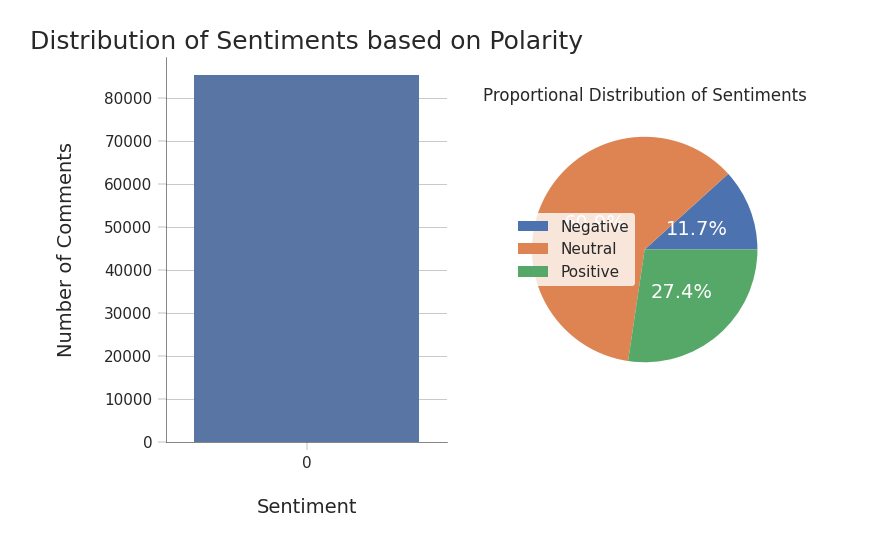

In [25]:
# Plotting the Count and Proportional Distribution of comments based on sentiment as per polarity
plt.subplot(1, 2, 1)

# Plotting the count of comments for each sentiment
sns.countplot(df['sentiment'],  )
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Distribution of Sentiments based on Polarity', fontsize=18)

plt.subplot(1, 2, 2)
# Plotting the proportional distribution of sentiments
plt.pie(x=[len(df[df['polarity'] < 0]), len(df[df['polarity'] == 0]),
           len(df[df['polarity'] > 0])], 
        labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%', pctdistance=0.5,
        textprops={'fontsize':14, 'color':'white'})
plt.title('Proportional Distribution of Sentiments')
plt.legend()
plt.show()

In [28]:
df["video_title"] = df["video_title"].fillna(value="")

In [30]:
from collections import Counter
#tf.columns = ["YouTube Comments", "Term Occurrence"]
#tf.head()
# most common words in video titles
title_words = list(df["video_title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('|', 17168),
 ('in', 16580),
 ('of', 14632),
 ('-', 11997),
 ('Israel', 9443),
 ('to', 9435),
 ('Hamas', 7120),
 ('Israeli', 7058),
 ('How', 6768),
 ('the', 6470),
 ('News', 5954),
 ('and', 5737),
 ('Gaza', 5314),
 ('at', 5112),
 ('a', 4903),
 ('The', 4901),
 ('on', 4829),
 ('/', 4798),
 ('from', 4706),
 ('with', 4634),
 ('BBC', 4363),
 ('during', 4281),
 ('speech', 4004),
 ('attack', 3956),
 ('के', 3647)]

In [32]:
df.video_channel_id

0        UChXQL4MqC4ihSVg3SFiszDg
1        UChXQL4MqC4ihSVg3SFiszDg
2        UChXQL4MqC4ihSVg3SFiszDg
3        UChXQL4MqC4ihSVg3SFiszDg
4        UChXQL4MqC4ihSVg3SFiszDg
                   ...           
85223    UCMliswJ7oukCeW35GSayhRA
85224    UCMliswJ7oukCeW35GSayhRA
85225    UCMliswJ7oukCeW35GSayhRA
85226    UCMliswJ7oukCeW35GSayhRA
85227    UCMliswJ7oukCeW35GSayhRA
Name: video_channel_id, Length: 85228, dtype: object

In [31]:
df.columns

Index(['News_ID', 'publish_date', 'Link', 'source_name', 'title', 'text',
       'youtube_link', 'news_language', 'label', 'all_link', 'videoId',
       'video_url', 'video_title', 'video_author', 'video_length',
       'video_channel_id', 'video_channel_url', 'video_description',
       'video_publish_date', 'video_rating', 'video_thumbnail_url',
       'video_views', 'video_age_restricted', 'CommentsData', 'commentText',
       'replycount', 'publishedAt', 'likeCount', 'authorDisplayName',
       'commentText_processed', 'comment_language', 'Clean_Comments',
       'polarity', 'sentiment'],
      dtype='object')

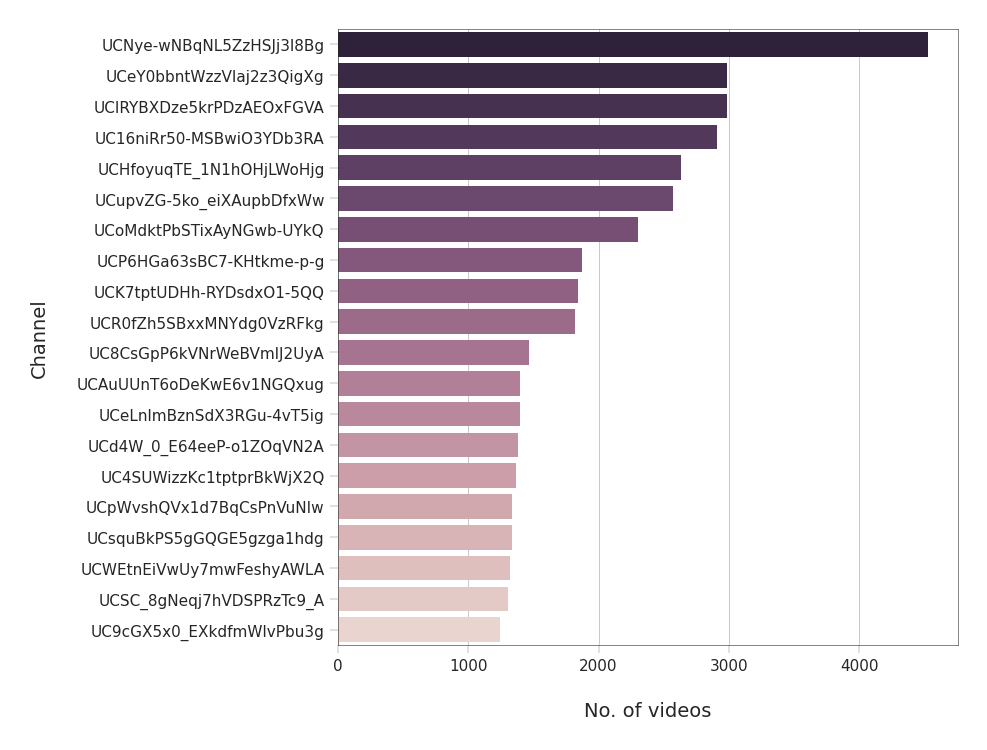

In [33]:
cdf = df.groupby("video_channel_id").size().reset_index(name="video_views") \
    .sort_values("video_views", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_views", y="video_channel_id", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")

## Video Views

Now plot a histogram for the views column to take a look at its distribution: to see how many videos have between 10 million and 20 million views, how many videos have between 20 million and 30 million views, and so on.

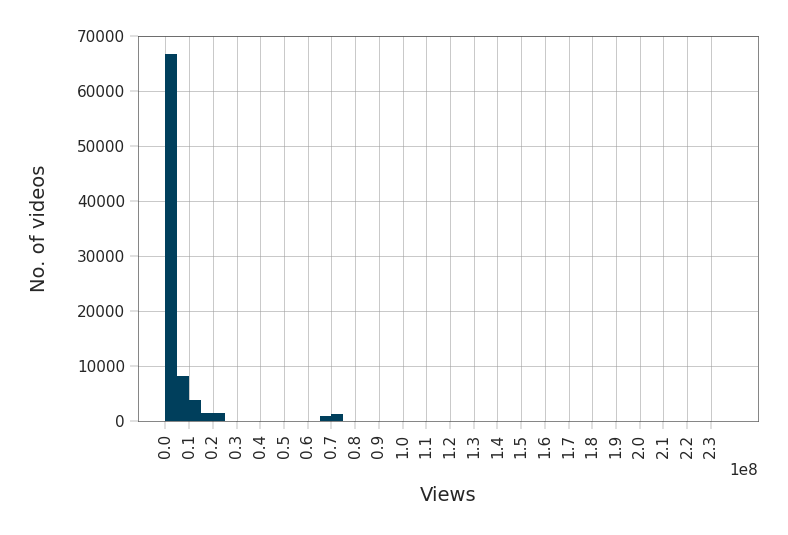

In [27]:
fig, ax = plt.subplots()
_ = sns.distplot(df["video_views"], kde=False, color=PLOT_COLORS[4], 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

Here vast majority of trending videos have 5 million views or less. We get the 5 million number by calculating

0.1×10^{8} / 2 = 5×10^{6}

Now let us plot the histogram just for videos with 25 million views or less to get a closer look at the distribution of the data

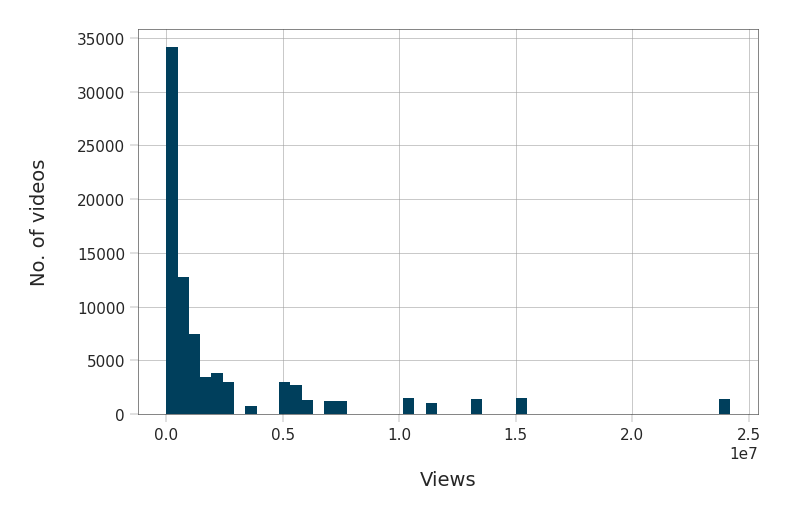

In [28]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["video_views"] < 25e6]["video_views"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

In [29]:
# Now we see that the majority of trending videos have 2 million views or less. 
# Let's see the exact percentage of videos less than 2 million views

df[df['video_views'] < 2e6]['video_views'].count() / df['video_views'].count() * 100

69.01380276055211

In [30]:
# 3M views
df[df['video_views'] < 3e6]['video_views'].count() / df['video_views'].count() * 100

76.00578939317275

In [31]:
# non-numeric cols
df.describe(include = ['O'])

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,video_channel_id,video_channel_url,video_publish_date,video_thumbnail_url,video_age_restricted,CommentsData,commentText,replycount,publishedAt,authorDisplayName
count,85228,85228,85228,85228,85228,85228,85228,85228,43995,4639,...,84983,84983,84983,84983,84983,85228,71585,71540,71540,71529
unique,220,46,220,37,219,214,302,19,51,7,...,222,222,191,301,2,85091,69181,272,71076,64245
top,gfc_50,2023-10-13,https://www.logicallyfacts.com/en/fact-check/f...,PolitiFact,victims of hamas attack on music festival were...,victims of hamas attack on music festival were...,https://www.youtube.com/watch?v=8xQ5wdilf4Y&ab...,en,False,"['https://mythdetector.ge/en/about-us/', 'http...",...,UCNye-wNBqNL5ZzHSJj3l8Bg,https://www.youtube.com/channel/UCNye-wNBqNL5Z...,2023-10-09 00:00:00,https://i.ytimg.com/vi/8xQ5wdilf4Y/hq720.jpg?s...,False,<br>,❤,0,2023-10-24T14:21:11Z,Dimples Harper Shannin Devfons Mcvicker Lil beL
freq,2860,6039,2860,12696,2860,2860,1463,58544,10396,1306,...,4529,4529,4421,1463,78371,59,66,35246,38,192


From the table above, we can see that there are 46 unique publish dates and 191 unique video publish dates, which means that our dataset contains collected data about trending videos over 30 days.


From video_channel_id description, we can see that there are 84983 videos (which is expected because our dataset contains 85228 entries), but we can see also that there are only 222 unique videos which means that some videos appeared on the trending videos list on more than one day. The table also tells us that the top frequent title is CNN team ducks from 'massive barrage of rocket... and that it appeared 516 times on the trending videos list.

But there is something strange in the description table above: Because there are 222 unique video IDs, we expect to have 222 unique video titles also, because we assume that each ID is linked to a corresponding title. One possible interpretation is that a trending video had some title when it appeared on the trending list, then it appeared again on another day but with a modified title. Similar explaination applies for description column as well. For video_publish_date column, the unique values are less than 222, but there is nothing strange here, because two different videos may be published at the same time.

To verify our interpretation for title column, let's take a look at an example where a trending video appeared more than once on the trending list but with different titles

In [32]:
grouped = df.groupby("video_channel_id")
groups = []
wanted_groups = []
for key, item in grouped:
    groups.append(grouped.get_group(key))

for g in groups:
    if len(g['video_title'].unique()) != 1:
        wanted_groups.append(g)

wanted_groups[0]

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,video_views,video_age_restricted,CommentsData,commentText,replycount,publishedAt,likeCount,authorDisplayName,commentText_processed,comment_language
49590,pubmedia_80,2023-10-26,http://www.politifact.com/article/2023/oct/26/...,PolitiFact,Did Donald Trump make these 27 campaign promis...,A liberal group says former President Donald T...,https://www.youtube.com/watch?v=oqI2M4jBliM,en,NaN,NaN,...,689808.00,False,The world would be a better place with Trump i...,The world would be a better place with Trump i...,35,2023-05-03T22:02:25Z,429.00,David Crane,NaN,NaN
49591,pubmedia_80,2023-10-26,http://www.politifact.com/article/2023/oct/26/...,PolitiFact,Did Donald Trump make these 27 campaign promis...,A liberal group says former President Donald T...,https://www.youtube.com/watch?v=oqI2M4jBliM,en,NaN,NaN,...,689808.00,False,"Wow, a POTUS that can speak an entire sentance...","Wow, a POTUS that can speak an entire sentance...",123,2023-05-06T00:16:21Z,836.00,petercallinicos,NaN,NaN
49592,pubmedia_80,2023-10-26,http://www.politifact.com/article/2023/oct/26/...,PolitiFact,Did Donald Trump make these 27 campaign promis...,A liberal group says former President Donald T...,https://www.youtube.com/watch?v=oqI2M4jBliM,en,NaN,NaN,...,689808.00,False,Watching here in Boston as a fan of President ...,Watching here in Boston as a fan of President ...,17,2023-05-05T19:27:34Z,150.00,Kitchen Table Issues with Michael D,NaN,NaN
49593,pubmedia_80,2023-10-26,http://www.politifact.com/article/2023/oct/26/...,PolitiFact,Did Donald Trump make these 27 campaign promis...,A liberal group says former President Donald T...,https://www.youtube.com/watch?v=oqI2M4jBliM,en,NaN,NaN,...,689808.00,False,"I&#39;M a Brit, no way in a hundred years wou...","I&#39;M a Brit, no way in a hundred years wou...",36,2023-05-06T19:29:06Z,344.00,TIC TOC,NaN,NaN
49594,pubmedia_80,2023-10-26,http://www.politifact.com/article/2023/oct/26/...,PolitiFact,Did Donald Trump make these 27 campaign promis...,A liberal group says former President Donald T...,https://www.youtube.com/watch?v=oqI2M4jBliM,en,NaN,NaN,...,689808.00,False,Two straight talking men not tiptoeing around ...,Two straight talking men not tiptoeing around ...,12,2023-05-06T14:14:57Z,164.00,Mr Brown,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63079,pubmedia_343,2023-10-18,https://fullfact.org/health/survey-sexual-assa...,Full Fact,Survey on sexual assault in surgery may not be...,18 October 2023\n\nThis comes from a survey of...,https://www.youtube.com/watch?v=9Y6UA3yil80,en,NaN,NaN,...,13331.00,False,The nhs has become joke. It should be broken u...,The nhs has become joke. It should be broken u...,1,2023-09-15T03:28:51Z,0.00,John -,NaN,NaN
63080,pubmedia_343,2023-10-18,https://fullfact.org/health/survey-sexual-assa...,Full Fact,Survey on sexual assault in surgery may not be...,18 October 2023\n\nThis comes from a survey of...,https://www.youtube.com/watch?v=9Y6UA3yil80,en,NaN,NaN,...,13331.00,False,I don’t care----0----2023-09-12T13:19:52Z----4...,I don’t care,0,2023-09-12T13:19:52Z,4.00,Abdurahman Mohamed,NaN,NaN
63081,pubmedia_343,2023-10-18,https://fullfact.org/health/survey-sexual-assa...,Full Fact,Survey on sexual assault in surgery may not be...,18 October 2023\n\nThis comes from a survey of...,https://www.youtube.com/watch?v=9Y6UA3yil80,en,NaN,NaN,...,13331.00,False,Feminist statistics----0----2023-09-12T17:17:2...,Feminist statistics,0,2023-09-12T17:17:26Z,2.00,alex smith,NaN,NaN
63082,pubmedia_343,2023-10-18,https://fullfact.org/health/survey-sexual-assa...,Full Fact,Survey on sexual assault in surgery may not be...,18 October 2023\n\nThis comes from a survey of...,https://www.youtube.com/watch?v=9Y6UA3yil80,en,NaN,NaN,...,13331.00,False,Bullying is rife too in the NHS----2----2023-0...,Bullying is rife too in the NHS,2,2023-09-12T18:18:20Z,1.00,shane humberston

We can see that this video appeared on the list with two different titles.

## How many trending video titles contain capitalized word?

Now we want to see how many trending video titles contain at least a capitalized word (e.g. CNN). To do that, we will add a new variable (column) to the dataset whose value is True if the video title has at least a capitalized word in it, and False otherwise

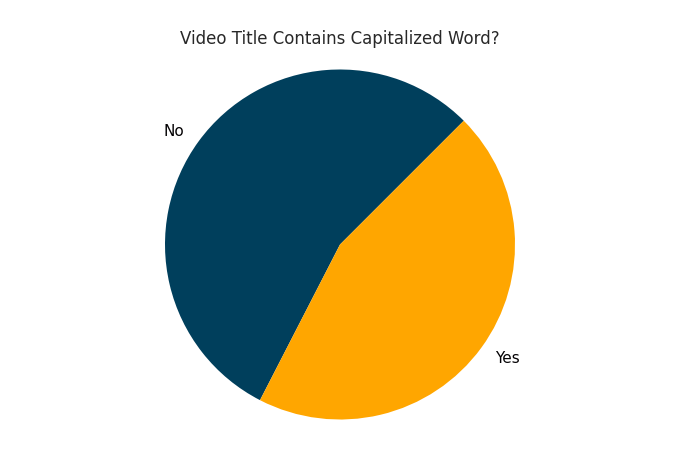

In [34]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df["videotitle_contains_capitalized"] = df["video_title"].apply(contains_capitalized_word)

value_counts = df["videotitle_contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Video Title Contains Capitalized Word?')

In [35]:
df["videotitle_contains_capitalized"].value_counts(normalize=True)

videotitle_contains_capitalized
False   0.55
True    0.45
Name: proportion, dtype: float64

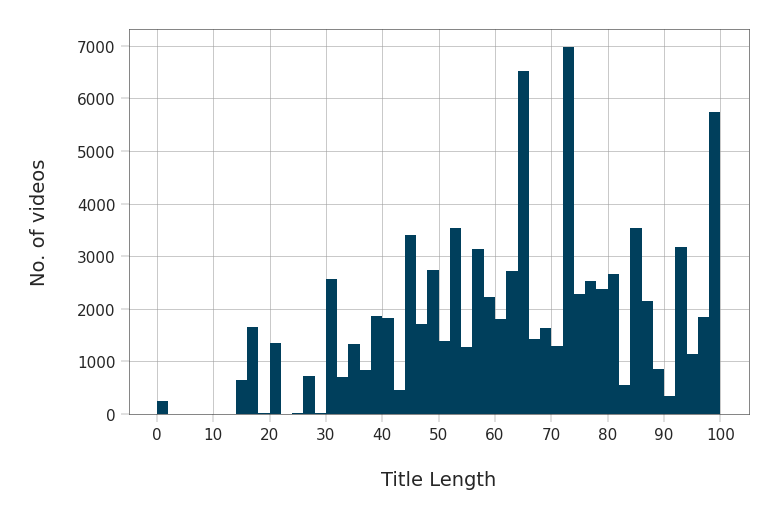

In [36]:
df["title_length"] = df["video_title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
_ = sns.distplot(df["title_length"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

We can see that title-length distribution resembles a normal distribution, where most videos have title lengths between 30 and 90 character approximately.

Now let's draw a scatter plot between title length and number of views to see the relationship between these two variables

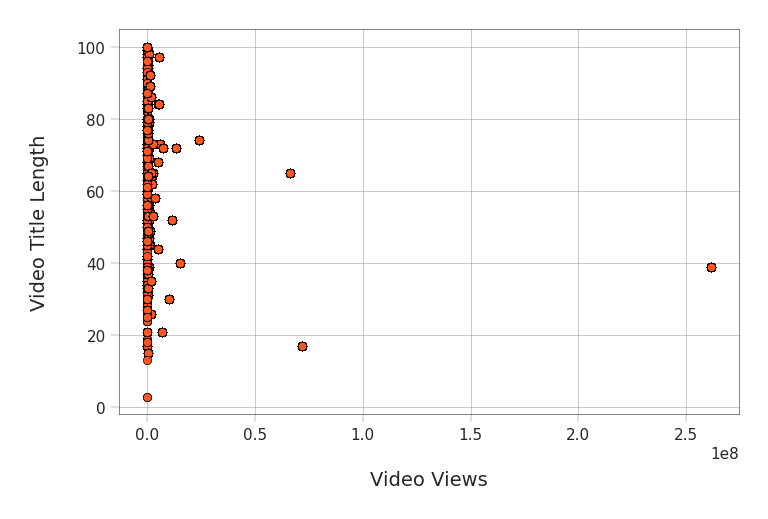

In [37]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['video_views'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Video Views", ylabel="Video Title Length")

In [39]:
#df.corr()
df.columns

Index(['News_ID', 'publish_date', 'Link', 'source_name', 'title', 'text',
       'youtube_link', 'news_language', 'label', 'all_link', 'videoId',
       'video_url', 'video_title', 'video_author', 'video_length',
       'video_channel_id', 'video_channel_url', 'video_description',
       'video_publish_date', 'video_rating', 'video_thumbnail_url',
       'video_views', 'video_age_restricted', 'CommentsData', 'commentText',
       'replycount', 'publishedAt', 'likeCount', 'authorDisplayName',
       'commentText_processed', 'comment_language', 'Clean_Comments',
       'polarity', 'sentiment', 'videotitle_contains_capitalized',
       'title_length'],
      dtype='object')

In [40]:
#Making a new dataframe for further use
ndf=df.copy()
ndf.to_csv('processed_fakevideo_withcomments.csv', index=False)

## Data cleaning

In [ ]:
df.shape

In [ ]:
df["video_description"] = df["video_description"].fillna(value="")
df["video_rating"] = df["video_rating"].fillna(value="")